In [1]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79165\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [234]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(RNN, self).__init__()
    self.rnn_cell = nn.RNNCell(input_size, hidden_size)
    self.hidden_size = hidden_size

  def forward(self, x, h=None):
    '''
    x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
    h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
    '''
    # инициализация тензора скрытых состояний
    # h = ...
    batch_size, seq_size, feat_size = x.size()
    x = x.permute(1, 0, 2)
    h = torch.zeros((batch_size, self.hidden_size))
    # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
    # h = RNNCell(s_t, h)
    hiddens = []
    hidden_t = h
    for t in range(seq_size):
        hidden_t = self.rnn_cell(x[t], hidden_t)
        hiddens.append(hidden_t)
        
    hiddens = torch.stack(hiddens)

    # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени
    return hiddens.permute(1, 0, 2)

In [235]:
df = pd.read_csv('surnames.csv')
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [236]:
le = LabelEncoder()
le.fit(df.nationality)

LabelEncoder()

In [237]:
df['coder'] = le.fit_transform(df.nationality.values)
df.head()

,surname,nationality,coder
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


In [238]:
class Vocab:
  def __init__(self, data):
    self.idx_to_token = dict()
    self.token_to_idx = dict()
    self.token_to_idx['<PAD>'] = 0
    self.idx_to_token[0] = '<PAD>'
    self.max_seq_len = 0
    k = 1
    for sur in data.values:
        for w in sur.lower():
            if w not in self.token_to_idx:
                self.token_to_idx[w] = k
                self.idx_to_token[k] = w
                k+=1
        if len(sur)>self.max_seq_len:
                self.max_seq_len = len(sur)
    self.vocab_len = len(self.idx_to_token)

In [239]:
vocab = Vocab(df.surname)

In [240]:
class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)'''
    surname_rep = []
    for sur in surname:
        rep = []
        for w in sur.lower():
            rep.append(self.vocab.token_to_idx[w])
        surname_rep.append(torch.tensor(rep+[0]*(vocab.max_seq_len-len(rep))))
    self.X_rep = torch.stack(surname_rep)
    
  def __len__(self):
    return len(self.X_rep)

  def __getitem__(self, idx):
    sample = self.X_rep[idx], self.y[idx]
    return sample

In [241]:
dataset = SurnamesDataset(df.surname, df.coder, vocab)
dataset.vectorize(df.surname.values)

In [242]:
z = next(iter(dataset))
z

(tensor([1, 2, 2, 3, 4, 2, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 4)

In [243]:
data_train, data_test = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)], generator=torch.Generator().manual_seed(42))

In [244]:
train_loader = DataLoader(data_train, batch_size = 50, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 50, shuffle = True)

# Class RNN

In [114]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = RNN(input_size = 50, hidden_size=130)
    self.fc1 = nn.Linear(130, 50)
    self.fc2 = nn.Linear(50, 18)
    self.emb = nn.Embedding(vocab.vocab_len, 50)
    self.emb.requires_grad = True
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = X[:, -1, :]
    X = nn.Tanh()(self.fc1(F.dropout(X, 0.5)))
    y_pred = self.fc2(F.dropout(X, 0.5))
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
test_losses = []

for i in range(91):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    if i%5==0:
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
        print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))
        if accuracy_score(y_true_test, y_pred_test)>0.7:
            break

epoch 0: train_loss = 2.35314575, test_loss = 2.28230382
Точность на тестовой выборке: 0.25956284153005466
epoch 5: train_loss = 2.18858246, test_loss = 2.06997379
Точность на тестовой выборке: 0.3843351548269581
epoch 10: train_loss = 1.81870160, test_loss = 1.73779374
Точность на тестовой выборке: 0.5336976320582878
epoch 15: train_loss = 1.54988395, test_loss = 1.50956004
Точность на тестовой выборке: 0.5796903460837887
epoch 20: train_loss = 1.32312245, test_loss = 1.29095601
Точность на тестовой выборке: 0.6607468123861566
epoch 25: train_loss = 1.21213345, test_loss = 1.19708270
Точность на тестовой выборке: 0.6775956284153005
epoch 30: train_loss = 1.12385827, test_loss = 1.25800855
Точность на тестовой выборке: 0.6721311475409836
epoch 35: train_loss = 1.07986005, test_loss = 1.23142311
Точность на тестовой выборке: 0.6826047358834244
epoch 40: train_loss = 0.99473292, test_loss = 1.17989263
Точность на тестовой выборке: 0.6944444444444444
epoch 45: train_loss = 1.02605263, tes

In [77]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [78]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

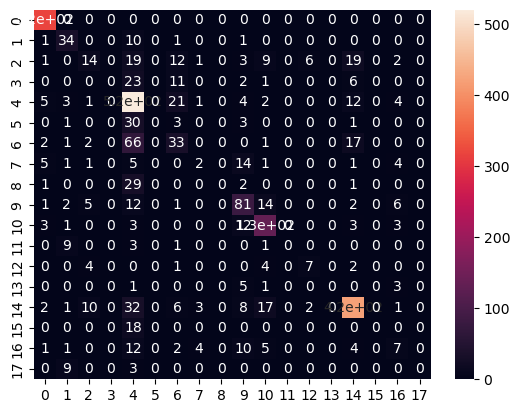

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [80]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.7144808743169399


In [134]:
surname = pd.Series(['dubrovskaya','akhmad'])
dataset.vectorize(surname)

In [140]:
y_pred = []
for x,y in dataset:
    y_pred.append(model(x.reshape(1,x.shape[0])))
y_pred_p = [y.argsort() for y in y_pred]
coder_rev = dict(zip(df.coder.values,df.nationality.values))

In [141]:
for i in range(2):
    y = y_pred_p[i]
    print('Фамилия:',surname[i],'три национальности:')
    print('Наиболее вероятно:', coder_rev[y[0][-1].item()])
    print('Вторая вероятность:', coder_rev[y[0][-2].item()])
    print('Третья вероятность:', coder_rev[y[0][-3].item()])
    print("")

Фамилия: dubrovskaya три национальности:
Наиболее вероятно: Russian
Вторая вероятность: Czech
Третья вероятность: Polish

Фамилия: akhmad три национальности:
Наиболее вероятно: Arabic
Вторая вероятность: English
Третья вероятность: Irish



1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [259]:
dataset = SurnamesDataset(df.surname, df.coder, vocab)
dataset.vectorize(df.surname.values)

In [260]:
data_train, data_test = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)], generator=torch.Generator().manual_seed(42))

In [261]:
train_loader = DataLoader(data_train, batch_size = 50, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 50, shuffle = True)

# RNN

In [262]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = nn.RNN(input_size = 50, hidden_size=150, batch_first=True)
    self.fc1 = nn.Linear(150, 50)
    self.fc2 = nn.Linear(50, 18)
    self.emb = nn.Embedding(vocab.vocab_len, 50)
    self.emb.requires_grad = True
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = X[0][:, -1, :]
    X = nn.Tanh()(self.fc1(F.dropout(X, 0.5)))
    y_pred = self.fc2(F.dropout(X, 0.5))
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

train_losses = []
test_losses = []

for i in range(71):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    if i%5==0:
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
        print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))
        if accuracy_score(y_true_test, y_pred_test)>0.71:
            break

epoch 0: train_loss = 2.40998054, test_loss = 2.29774304
Точность на тестовой выборке: 0.2563752276867031
epoch 5: train_loss = 2.18885249, test_loss = 2.13022674
Точность на тестовой выборке: 0.35792349726775957
epoch 10: train_loss = 1.87835140, test_loss = 1.81283900
Точность на тестовой выборке: 0.5095628415300546
epoch 15: train_loss = 1.61811953, test_loss = 1.59860583
Точность на тестовой выборке: 0.5769581056466302
epoch 20: train_loss = 1.40230665, test_loss = 1.41740217
Точность на тестовой выборке: 0.6265938069216758
epoch 25: train_loss = 1.24555419, test_loss = 1.30806891
Точность на тестовой выборке: 0.6561930783242259
epoch 30: train_loss = 1.14602073, test_loss = 1.22093874
Точность на тестовой выборке: 0.6826047358834244
epoch 35: train_loss = 1.07404205, test_loss = 1.28262091
Точность на тестовой выборке: 0.6753187613843351
epoch 40: train_loss = 1.00448999, test_loss = 1.17063605
Точность на тестовой выборке: 0.686247723132969
epoch 45: train_loss = 0.96336565, test

In [271]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [272]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

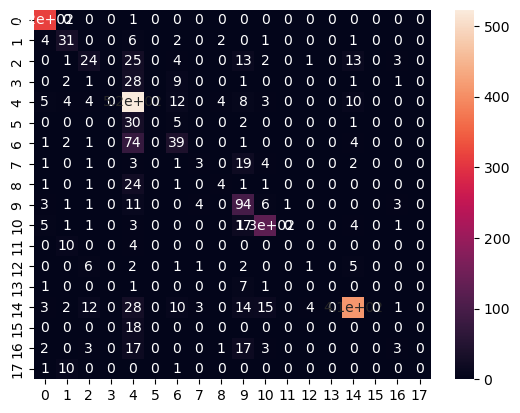

In [273]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [274]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.7172131147540983


# LSTM

In [303]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = nn.LSTM(input_size = 50, hidden_size=120, batch_first=True)
    self.fc1 = nn.Linear(120, 50)
    self.fc2 = nn.Linear(50, 18)
    self.emb = nn.Embedding(vocab.vocab_len, 50)
    self.emb.requires_grad = True
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = X[0][:, -1, :]
    X = nn.Tanh()(self.fc1(F.dropout(X, 0.5)))
    y_pred = self.fc2(F.dropout(X, 0.5))
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
test_losses = []

for i in range(41):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    if i%5==0:
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
        print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 2.36286974, test_loss = 2.20310571
Точность на тестовой выборке: 0.30510018214936246
epoch 5: train_loss = 1.55032020, test_loss = 1.46929058
Точность на тестовой выборке: 0.6124772313296903
epoch 10: train_loss = 1.15568857, test_loss = 1.14123590
Точность на тестовой выборке: 0.6880692167577414
epoch 15: train_loss = 0.97068036, test_loss = 1.01166115
Точность на тестовой выборке: 0.7181238615664846
epoch 20: train_loss = 0.85429162, test_loss = 0.98770029
Точность на тестовой выборке: 0.7354280510018215
epoch 25: train_loss = 0.78106372, test_loss = 0.95637966
Точность на тестовой выборке: 0.7413479052823315
epoch 30: train_loss = 0.70103641, test_loss = 0.98700803
Точность на тестовой выборке: 0.7431693989071039
epoch 35: train_loss = 0.65856435, test_loss = 0.96179886
Точность на тестовой выборке: 0.7449908925318761
epoch 40: train_loss = 0.57920847, test_loss = 1.00218921
Точность на тестовой выборке: 0.7372495446265938


In [304]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [305]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

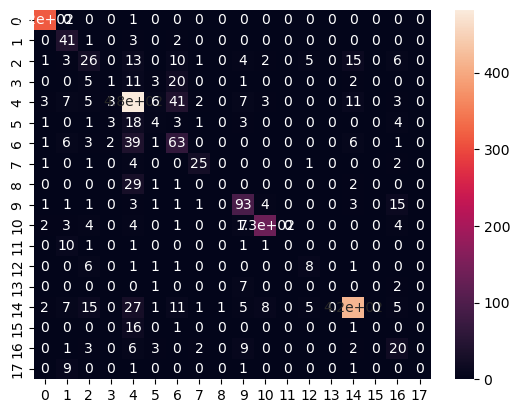

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [307]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.7408925318761385


# GRU

In [308]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = nn.GRU(input_size = 50, hidden_size=120, batch_first=True)
    self.fc1 = nn.Linear(120, 50)
    self.fc2 = nn.Linear(50, 18)
    self.emb = nn.Embedding(vocab.vocab_len, 50)
    self.emb.requires_grad = True
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = X[0][:, -1, :]
    X = nn.Tanh()(self.fc1(F.dropout(X, 0.5)))
    y_pred = self.fc2(F.dropout(X, 0.5))
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_losses = []
test_losses = []

for i in range(41):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    if i%5==0:
        print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
        print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 2.34342134, test_loss = 2.20806741
Точность на тестовой выборке: 0.3069216757741348
epoch 5: train_loss = 1.32308806, test_loss = 1.30999002
Точность на тестовой выборке: 0.6662112932604736
epoch 10: train_loss = 1.08541748, test_loss = 1.16428209
Точность на тестовой выборке: 0.6867030965391621
epoch 15: train_loss = 0.92594172, test_loss = 1.06579430
Точность на тестовой выборке: 0.7094717668488161
epoch 20: train_loss = 0.81125193, test_loss = 0.99153734
Точность на тестовой выборке: 0.7367941712204007
epoch 25: train_loss = 0.73016611, test_loss = 0.97249154
Точность на тестовой выборке: 0.7449908925318761
epoch 30: train_loss = 0.65208777, test_loss = 1.03037647
Точность на тестовой выборке: 0.7226775956284153
epoch 35: train_loss = 0.59411137, test_loss = 1.03117756
Точность на тестовой выборке: 0.7317850637522769
epoch 40: train_loss = 0.52260941, test_loss = 1.02622584
Точность на тестовой выборке: 0.7463570127504554


In [309]:
y_pred = []
y_true = []
for x,y in test_loader:
    y_pred.extend(model(x))
    y_true.extend(y)
y_pred = list(map(lambda x: torch.argmax(x).item(), y_pred))
y_true = list(map(lambda x: x.item(), y_true))

In [310]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

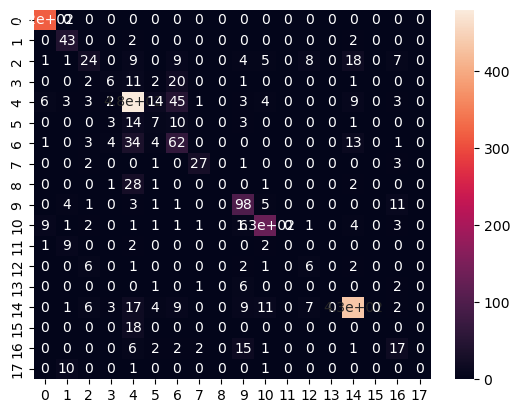

In [311]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True)
plt.show()

In [312]:
from sklearn.metrics import accuracy_score
print('Точность на тестовой выборке:', accuracy_score(y_true, y_pred))

Точность на тестовой выборке: 0.7509107468123861


## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [150]:
df_positive = pd.read_table('positive_reviews.txt', header = None)
df_positive.columns = ['review']
df_positive['target'] = 0
df_positive.head()

,review,target
0,the rock is destined to be the 21st century's ...,0
1,"the gorgeously elaborate continuation of "" the...",0
2,effective but too-tepid biopic,0
3,if you sometimes like to go to the movies to h...,0
4,"emerges as something rare , an issue movie tha...",0


In [151]:
df_negative = pd.read_table('negative_reviews.txt', header = None)
df_negative.columns = ['review']
df_negative['target'] = 1
df_negative.head()

,review,target
0,"simplistic , silly and tedious .",1
1,"it's so laddish and juvenile , only teenage bo...",1
2,exploitative and largely devoid of the depth o...,1
3,[garbus] discards the potential for pathologic...,1
4,a visually flashy but narratively opaque and e...,1


In [152]:
df = pd.concat([df_positive, df_negative], ignore_index = True).sample(frac=1).reset_index(drop=True)
df

,review,target
0,the whole mildly pleasant outing -- the r rati...,0
1,weiss and speck never make a convincing case f...,1
2,"i was hoping that it would be sleazy and fun ,...",1
3,the film is filled with humorous observations ...,0
4,a tour de force of modern cinema .,0
...,...,...
10657,it's difficult to imagine that a more confused...,1
10658,costner's warm-milk persona is just as ill-fit...,1
10659,the furious coherence that [deniro] brings to ...,1
10660,disappointing in comparison to other recent wa...,1


In [153]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df.target, test_size=0.2, random_state=42)

In [154]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z.,|?]', r' ',text)
    return text

In [155]:
class Vocab:
  def __init__(self, data):
    self.idx_to_token = dict()
    self.token_to_idx = dict()
    self.idx_to_token[0] = '<UNK>'
    self.token_to_idx['<UNK>'] = 0
    k = 1
    self.max_len = 0
    for sur in data.values:
        for w in word_tokenize(preprocess_text(sur[0])):
            if w not in self.token_to_idx:
                self.token_to_idx[w] = k
                self.idx_to_token[k] = w
                k+=1
        if len(word_tokenize(preprocess_text(sur[0])))>self.max_len:
            self.max_len = len(word_tokenize(preprocess_text(sur[0])))+10
    self.vocab_len = len(self.idx_to_token)
    

In [156]:
vocab = Vocab(X_train)

In [157]:
class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, review):
    '''Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2)'''
    review_rep = []
    for rev in review:
        rep = []
        for w in word_tokenize(preprocess_text(rev[0])):
            if w in vocab.token_to_idx:
                rep.append(vocab.token_to_idx[w])
            else:
                rep.append(0)
        review_rep.append(torch.tensor(rep+[0]*(vocab.max_len-len(rep))))
    self.X_rep = torch.stack(review_rep)
    
  def __len__(self):
    return len(self.X_rep)

  def __getitem__(self, idx):
    sample = self.X_rep[idx], self.y.values[idx]
    return sample

In [158]:
data_train = ReviewDataset(X_train, y_train, vocab)
data_train.vectorize(X_train.values)

In [159]:
data_test = ReviewDataset(X_test, y_test, vocab)
data_test.vectorize(X_test.values)

In [160]:
train_loader = DataLoader(data_train, batch_size = 24, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 24, shuffle = True)

In [161]:
z = next(iter(data_train))
z

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  3, 11, 12,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 0)

In [162]:
z = next(iter(data_test))
z

(tensor([   21,     0,  2269, 12127,    56,  3094,    21,   481,   972,    21,
          6722,    12,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 1)

# RNN

In [163]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = nn.RNN(input_size = 30, hidden_size=35, batch_first=True, num_layers = 2, dropout = 0.5)
    self.fc1 = nn.Linear(35, 2)
    self.emb = nn.Embedding(vocab.vocab_len, 30)
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = torch.sum(X[0], dim=1)
    y_pred = self.fc1(X)
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

train_losses = []
test_losses = []

for i in range(15):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 0.96048570, test_loss = 0.89480341
Точность на тестовой выборке: 0.5035161744022504
epoch 1: train_loss = 0.75671767, test_loss = 0.74815306
Точность на тестовой выборке: 0.5175808720112518
epoch 2: train_loss = 0.73360537, test_loss = 0.70470716
Точность на тестовой выборке: 0.5307079231129864
epoch 3: train_loss = 0.71469384, test_loss = 0.69839958
Точность на тестовой выборке: 0.5428973277074542
epoch 4: train_loss = 0.70110209, test_loss = 0.70251957
Точность на тестовой выборке: 0.5532114392873887
epoch 5: train_loss = 0.67617850, test_loss = 0.70241682
Точность на тестовой выборке: 0.5480543834974215
epoch 6: train_loss = 0.66465380, test_loss = 0.66176479
Точность на тестовой выборке: 0.5977496483825597
epoch 7: train_loss = 0.62513032, test_loss = 0.65238281
Точность на тестовой выборке: 0.6315049226441631
epoch 8: train_loss = 0.60803106, test_loss = 0.65827893
Точность на тестовой выборке: 0.6469760900140648
epoch 9: train_loss = 0.56827882, test_loss = 

In [169]:
surname = pd.Series([['a thoughtful and perfect love story. i love it'],['it was boring and just awful! I do not advise anyone to watch this movie']])
data_test.vectorize(surname)

In [170]:
y_pred = []
for x,y in data_test:
    y_pred.append(model(x.reshape(1,x.shape[0])))

In [171]:
for i in range(2):
    y = y_pred[i]
    print('Отзыв:',surname[i])
    if y.argmax()==1:
        print('С вероятностью ', max(nn.Softmax(dim = 0)(y.float()[0])).item(), 'отрицательный отзыв')
    else:
        print('С вероятностью ', max(nn.Softmax(dim = 0)(y.float()[0])).item(), 'положительный отзыв')

Отзыв: ['a thoughtful and perfect love story. i love it']
С вероятностью  0.8833206295967102 положительный отзыв
Отзыв: ['it was boring and just awful! I do not advise anyone to watch this movie']
С вероятностью  0.960119366645813 отрицательный отзыв


# LSTM

In [172]:
data_train = ReviewDataset(X_train, y_train, vocab)
data_train.vectorize(X_train.values)

In [173]:
data_test = ReviewDataset(X_test, y_test, vocab)
data_test.vectorize(X_test.values)

In [174]:
train_loader = DataLoader(data_train, batch_size = 24, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 24, shuffle = True)

In [176]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = nn.LSTM(input_size = 30, hidden_size=20, batch_first=True, num_layers = 2, dropout = 0.5)
    self.fc1 = nn.Linear(20, 2)
    self.emb = nn.Embedding(vocab.vocab_len, 30)
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = torch.sum(X[0], dim=1)
    y_pred = self.fc1(X)
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

train_losses = []
test_losses = []

for i in range(15):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 0.81113532, test_loss = 0.69254009
Точность на тестовой выборке: 0.5433661509610876
epoch 1: train_loss = 0.69001862, test_loss = 0.68332348
Точность на тестовой выборке: 0.5564932020628223
epoch 2: train_loss = 0.67258851, test_loss = 0.66915452
Точность на тестовой выборке: 0.5925925925925926
epoch 3: train_loss = 0.64402151, test_loss = 0.64930208
Точность на тестовой выборке: 0.6216596343178622
epoch 4: train_loss = 0.60708175, test_loss = 0.64710461
Точность на тестовой выборке: 0.6413502109704642
epoch 5: train_loss = 0.56954438, test_loss = 0.64456148
Точность на тестовой выборке: 0.6568213783403657
epoch 6: train_loss = 0.51602862, test_loss = 0.64039963
Точность на тестовой выборке: 0.6704172526957337
epoch 7: train_loss = 0.46597960, test_loss = 0.63575472
Точность на тестовой выборке: 0.6901078293483357
epoch 8: train_loss = 0.41404574, test_loss = 0.64112958
Точность на тестовой выборке: 0.6863572433192686
epoch 9: train_loss = 0.37103494, test_loss = 

In [177]:
surname = pd.Series([['a thoughtful and perfect love story. i love it'],['it was boring and just awful! I do not advise anyone to watch this movie']])
data_test.vectorize(surname)

In [178]:
y_pred = []
for x,y in data_test:
    y_pred.append(model(x.reshape(1,x.shape[0])))

In [179]:
for i in range(2):
    y = y_pred[i]
    print('Отзыв:',surname[i])
    if y.argmax()==1:
        print('С вероятностью ', max(nn.Softmax(dim = 0)(y.float()[0])).item(), 'отрицательный отзыв')
    else:
        print('С вероятностью ', max(nn.Softmax(dim = 0)(y.float()[0])).item(), 'положительный отзыв')

Отзыв: ['a thoughtful and perfect love story. i love it']
С вероятностью  0.995598554611206 положительный отзыв
Отзыв: ['it was boring and just awful! I do not advise anyone to watch this movie']
С вероятностью  0.9978995323181152 отрицательный отзыв


# GRU

In [180]:
data_train = ReviewDataset(X_train, y_train, vocab)
data_train.vectorize(X_train.values)

In [181]:
data_test = ReviewDataset(X_test, y_test, vocab)
data_test.vectorize(X_test.values)

In [182]:
train_loader = DataLoader(data_train, batch_size = 24, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 24, shuffle = True)

In [195]:
losses = []

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.rnn = nn.GRU(input_size = 30, hidden_size=20, batch_first=True, num_layers = 2, dropout = 0.5)
    self.fc1 = nn.Linear(20, 2)
    self.emb = nn.Embedding(vocab.vocab_len, 30)
    
  def forward(self, X):
    X = self.emb(torch.LongTensor(X))
    X = self.rnn(X)
    X = torch.sum(X[0], dim=1)
    y_pred = self.fc1(X)
    return y_pred

model = Model()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

train_losses = []
test_losses = []

for i in range(15):
    model.train()
    losses_epoch_train = []
    losses_epoch_test = []
    y_pred_test = []
    y_true_test = []
    for x_example, y_example in train_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_train.append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    for x_example, y_example in test_loader:
        y_pred = model(x_example)
    
        loss = criterion(y_pred, y_example.long())
        losses_epoch_test.append(loss.item())
        
        y_pred_test.extend(y_pred)
        y_true_test.extend(y_example)
    
    train_losses.append(np.mean(losses_epoch_train))
    test_losses.append(np.mean(losses_epoch_test))
    y_pred_test = list(map(lambda x: torch.argmax(x).item(), y_pred_test))
    y_true_test = list(map(lambda x: x.item(), y_true_test))
    print(f'epoch {i}: train_loss = {np.mean(losses_epoch_train):.8f}, test_loss = {np.mean(losses_epoch_test):.8f}') 
    print('Точность на тестовой выборке:', accuracy_score(y_true_test, y_pred_test))

epoch 0: train_loss = 1.01120869, test_loss = 0.74960507
Точность на тестовой выборке: 0.522737927801219
epoch 1: train_loss = 0.72243804, test_loss = 0.70409981
Точность на тестовой выборке: 0.5372714486638537
epoch 2: train_loss = 0.69495794, test_loss = 0.68050908
Точность на тестовой выборке: 0.5714955461790905
epoch 3: train_loss = 0.67928318, test_loss = 0.66982998
Точность на тестовой выборке: 0.5855602437880919
epoch 4: train_loss = 0.66365116, test_loss = 0.66351056
Точность на тестовой выборке: 0.6038443506797937
epoch 5: train_loss = 0.63497727, test_loss = 0.65873900
Точность на тестовой выборке: 0.6216596343178622
epoch 6: train_loss = 0.58925470, test_loss = 0.63502559
Точность на тестовой выборке: 0.6511954992967651
epoch 7: train_loss = 0.54216104, test_loss = 0.62724294
Точность на тестовой выборке: 0.6704172526957337
epoch 8: train_loss = 0.48982732, test_loss = 0.62063574
Точность на тестовой выборке: 0.6858884200656352
epoch 9: train_loss = 0.43794029, test_loss = 0

In [196]:
surname = pd.Series([['a thoughtful and perfect love story. i love it'],['it was boring and just awful! I do not advise anyone to watch this movie']])
data_test.vectorize(surname)

In [197]:
y_pred = []
for x,y in data_test:
    y_pred.append(model(x.reshape(1,x.shape[0])))

In [198]:
for i in range(2):
    y = y_pred[i]
    print('Отзыв:',surname[i])
    if y.argmax()==1:
        print('С вероятностью ', max(nn.Softmax(dim = 0)(y.float()[0])).item(), 'отрицательный отзыв')
    else:
        print('С вероятностью ', max(nn.Softmax(dim = 0)(y.float()[0])).item(), 'положительный отзыв')

Отзыв: ['a thoughtful and perfect love story. i love it']
С вероятностью  0.9996867179870605 положительный отзыв
Отзыв: ['it was boring and just awful! I do not advise anyone to watch this movie']
С вероятностью  0.9998295307159424 отрицательный отзыв
